In [2]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools import DuckDuckGoSearchResults
from langgraph.graph.message import add_messages

from config import geminiKey

## Graph State

In [3]:
class ChatState(TypedDict):
    messages: Annotated[list, add_messages]

In [4]:
chat = ChatGoogleGenerativeAI(api_key=geminiKey, model="gemini-1.5-flash")

# LangGraph basic chatbot

In [ ]:
def chatbot(state: ChatState):
    # print("="*50)
    # print(state)
    # print("="*50)
    return {"messages": [chat.invoke(state["messages"])]}

In [42]:
graph_builder = StateGraph(ChatState)

# Add node
graph_builder.add_node("llm", chatbot)

# Add edges
graph_builder.add_edge(START, "llm")
graph_builder.add_edge("llm", END)

# compile graph
agent = graph_builder.compile()

In [16]:
# Visualize Graph
from IPython.display import display, Image

def visualizeGraph(graph):
    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except Exception:
        print("Cannot draw graph")
visualizeGraph(agent)

NameError: name 'agent' is not defined

In [ ]:
res = agent.invoke({"messages": ["Hi"]})
res["messages"][-1].content

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='326a2e08-19c2-4152-8280-282989426195')]}


'Hi there! How can I help you today?'

## Integrating tools

In [49]:
# from langchain_tavily import TavilySearch
# tool = TavilySearch(max_results=5, search_depth="basic")

In [5]:
tool = DuckDuckGoSearchResults()
# tool("langgraph")

In [6]:
def calculator(equation: str) -> str:
    """
    Evaluate a valid python mathamatical expression.
    Args:
        expression (str): Equation to solve
    Return:
        str: format "Result of <expression> = <result>"
    """
    return f"Resultof {equation} = {eval(equation)}"

In [7]:
tools = [tool, calculator]
llm_with_tools = chat.bind_tools(tools)

In [8]:
from langgraph.prebuilt import ToolNode, tools_condition

In [9]:
def chatbotv2(state: ChatState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [10]:
builder = StateGraph(ChatState)

# Nodes
builder.add_node("llm", chatbotv2)
builder.add_node("tools", ToolNode(tools))

# Edges
builder.add_edge(START, "llm")
builder.add_conditional_edges("llm", tools_condition)
builder.add_edge("tools", END)

agentv2 = builder.compile()

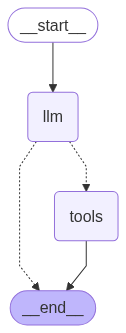

In [60]:
visualizeGraph(agentv2)

In [62]:
res1 = agentv2.invoke({"messages": "Tell me about grok's latest llm"})
res2 = agentv2.invoke({"messages": "find 23% of 892"})
res3 = agentv2.invoke({"messages": "tell me about which tools you have access."})

print("="*70)
for res in [res1, res2, res3]:
    print(res["messages"][-1].content)
    print("="*70)

I am sorry, I do not have access to real-time information, including news about specific companies like Grok.  My knowledge about LLMs is based on the data I was trained on, which is not current.  To find the latest information on Grok's LLMs, I suggest searching online using a search engine like Google, DuckDuckGo, or Bing.
Resultof 0.23 * 892 = 205.16
I have access to the following tools:

*   **`default_api.duckduckgo_results_json(query: str)`**: This function takes a search query as a string and returns a JSON object containing results from DuckDuckGo.  This is useful for answering questions about current events.

*   **`default_api.calculator(equation: str)`**: This function takes a mathematical expression as a string and returns a string containing the result of the calculation.  It's useful for performing simple calculations.


In [11]:
res = agentv2.invoke({"messages": "sqrt of 16"})

for m in res['messages']:
    m.pretty_print()

================================ Human Message =================================

sqrt of 16
================================== Ai Message ==================================
Tool Calls:
  calculator (e6236999-637f-4822-a474-067fbe3c32d9)
 Call ID: e6236999-637f-4822-a474-067fbe3c32d9
  Args:
    equation: 16**0.5
================================= Tool Message =================================
Name: calculator

Resultof 16**0.5 = 4.0


## ReACT Agent

In [13]:
builder = StateGraph(ChatState)

# Nodes
builder.add_node("llm", chatbotv2)
builder.add_node("tools", ToolNode(tools))

# Edges
builder.add_edge(START, "llm")
builder.add_conditional_edges("llm", tools_condition)
builder.add_edge("tools", "llm")

react_agent = builder.compile()

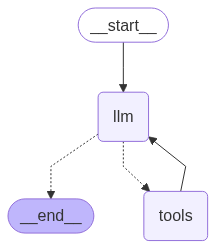

In [17]:
visualizeGraph(react_agent)

In [22]:
res = react_agent.invoke({"messages": "What is transformer architecture and give square of 5."})
for m in res["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is transformer architecture and give square of 5.
================================== Ai Message ==================================

Transformer architecture is a deep learning model architecture primarily used in natural language processing (NLP).  It relies on a mechanism called "self-attention" which allows the model to weigh the importance of different words in an input sequence when processing it.  This is in contrast to recurrent neural networks (RNNs) which process sequences sequentially.  The ability to process all words in parallel makes transformers significantly faster to train than RNNs, and they have achieved state-of-the-art results on many NLP tasks.  Key components include encoder and decoder stacks, each composed of multiple layers of self-attention and feed-forward neural networks.
Tool Calls:
  calculator (f00ec325-e74f-4186-bff1-b6f6a94068c3)
 Call ID: f00ec325-e74f-4186-bff1-b6f6a

## Integrating memory in AI Agent

In [23]:
from langgraph.checkpoint.memory import MemorySaver

In [24]:
memory = MemorySaver()
config={"configurable":{"thread_id":"1"}}

In [25]:
agentv3 = builder.compile(checkpointer=memory)

In [29]:
res1 = agentv3.invoke({"messages": "Hello I am Lakshy Gehlot"}, config=config)
res2 = agentv3.invoke({"messages": "Tell me, what is my name?"}, config=config)

print(res1["messages"][-1].content)
print("-"*80)
print(res2["messages"][-1].content)

Hello again, Lakshy Gehlot!  What can I do for you?
--------------------------------------------------------------------------------
Your name is Lakshy Gehlot.


## Streaming

In [33]:
for chunk in agentv3.stream({'messages':"Hi, tell me about grok 4."},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hello I am Lakshy Gehlot', additional_kwargs={}, response_metadata={}, id='14359f1d-f245-4276-a3eb-c25b3846e27a'), AIMessage(content='Hello Lakshy Gehlot! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--21e38100-4b3a-4c5e-ae16-4a8553404347-0', usage_metadata={'input_tokens': 94, 'output_tokens': 14, 'total_tokens': 108, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Tell me, what is my name?', additional_kwargs={}, response_metadata={}, id='11172ebd-188c-49b5-9705-8d3cd77da7f8'), AIMessage(content='Your name is Lakshy Gehlot.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--5799b510-8e53-43d5-9bd1-e3368ebe76ae-0', usage_metadata={'input_tokens': 115, 'output_tokens': 9, 'total_tokens